In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import xgboost as xgb
from xgboost import XGBRegressor

from imblearn.over_sampling import SMOTE

import pickle

import os

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/ClickStream_Project/Preprocessed_Data/processed_data.csv'

In [ ]:
data = pd.read_csv(file_path)
data.head()

,month,day,country,page1_main_category,colour,location,model_photography,page,avg_price,unique_products,browsing_depth,weekend,high_price_preference
0,6,22,29,3,13,1,2,2,46.928571,55,4,1,1
1,5,19,29,2,13,3,1,2,57.666667,4,2,0,1
2,7,15,29,3,9,5,1,1,38.900000,9,3,0,1
3,5,2,29,2,2,4,1,1,51.666667,5,2,0,0
4,6,9,29,2,9,5,1,2,52.333333,12,2,0,1


In [ ]:
val = data.drop('high_price_preference', axis = 1)
tar = data['high_price_preference']

In [ ]:
fs = XGBRegressor(n_estimators = 200, random_state = 90)

In [ ]:
fs.fit(val, tar)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
selected = pd.DataFrame({
    "col": val.columns,
    'sco':fs.feature_importances_
}).sort_values('sco', ascending = False).head(9)['col'].to_list()

In [ ]:
val = val[selected]

tar = tar

In [ ]:
tar.value_counts()

,count
high_price_preference,
0,80230
1,52149


In [ ]:
smote = SMOTE()

In [ ]:
os_val, os_tar = smote.fit_resample(val, tar)

In [ ]:
os_tar.value_counts()

,count
high_price_preference,
1,80230
0,80230


In [ ]:
x_train, x_test, tr_lab, ts_lab = train_test_split(os_val, os_tar, test_size = 0.2, random_state = 65)

#### Logistic Regression

In [ ]:
def build_logistic_regression(x_train, x_test, tr_lab, ts_lab):

    print("\n----------Building Logistic Regression----------")

    param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000]
    }

    lr_model = LogisticRegression(random_state=65)

    random_search = RandomizedSearchCV(
        lr_model,
        param_grid,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)

    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title('Logistic Regression Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return best_model

#### Decision Tree

In [ ]:
def build_decision_tree(x_train, x_test, tr_lab, ts_lab):

    print("\n----------Building Decision Tree----------")

    param_grid = {
        'max_depth': [None, 5, 10, 15, 20, 30],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 6],
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random']
    }

    dt_model = DecisionTreeClassifier(random_state=65)

    random_search = RandomizedSearchCV(
        dt_model,
        param_grid,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)

    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Decision Tree Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return best_model

#### Random Forest

In [ ]:
def build_random_forest(x_train, x_test, tr_lab, ts_lab):

    print('\n----------Building Random Forest----------')

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    rf_model = RandomForestClassifier(random_state=65, warm_start=True, n_jobs=-1)

    random_search = RandomizedSearchCV(
        rf_model,
        param_grid,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)

    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title('Random Forest Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return best_model

#### XG Boost

In [ ]:
def build_xgboost(x_train, x_test, tr_lab, ts_lab):

    print('\n----------Building XGBoost----------')

    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_lambda': [1, 2, 5]
    }

    xgb_model = xgb.XGBClassifier(random_state=65, tree_method="hist", gpu_id=0)

    random_search = RandomizedSearchCV (
        xgb_model,
        param_grid,
        n_iter = 20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
    )


    random_search.fit(x_train, tr_lab, eval_set=[(x_test, ts_lab)])

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)

    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('XGBoost Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return best_model


#### Neural Networks

In [ ]:
def build_neural_network(x_train, x_test, tr_lab, ts_lab):

    print("\n----------Building Neural Network----------")

    nn_model = Sequential([
        Dense(100, activation='relu', input_shape = (x_train.shape[1],)),
        Dropout(0.2),
        Dense(75, activation= 'relu'),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer = Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = nn_model.fit(x_train, tr_lab,
                        validation_split=0.2,
                        epochs=50,
                        batch_size=32,
                        callbacks=[early_stopping],
                        verbose=1)

    ts_pred = (nn_model.predict(x_test) > 0.5).astype(int)

    ts_probs = nn_model.predict(x_test).flatten()

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)

    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title('Neural Network Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return nn_model, history

#### Comparing Models

In [ ]:
def compare_models(models_dict, x_test, ts_lab):

    print("\n----------Comparing Models----------")

    results = {}

    for name, model in models_dict.items():
        if hasattr(model, "predict"):
            ts_probs = model.predict(x_test)
            ts_pred = (ts_probs > 0.5).astype(int)
        else:
            ts_pred = model.predict(x_test)

        accuracy = accuracy_score(ts_lab, ts_pred)
        auc_score = roc_auc_score(ts_lab, ts_pred)
        results[name] = {
            'Accuracy': accuracy,
            'Roc-Auc Score': auc_score,
            'Predictions': ts_pred

        }

    comparison = pd.DataFrame(results).T[['Accuracy', 'Roc-Auc Score']]

    comparison = comparison.sort_values('Accuracy', ascending = False)

    print(comparison)

    best_model_name = comparison.index[0]

    best_model = models_dict[best_model_name]

    plt.figure(figsize=(5, 4))
    sns.barplot(x=comparison.index, y='Accuracy', data=comparison)
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return comparison, results, best_model, best_model_name

#### Final Call

In [ ]:
def run_all_models(x_train, x_test, tr_lab, ts_lab):

    lr_model = build_logistic_regression(x_train, x_test, tr_lab, ts_lab)
    dt_model = build_decision_tree(x_train, x_test, tr_lab, ts_lab)
    rf_model = build_random_forest(x_train, x_test, tr_lab, ts_lab)
    xgb_model = build_xgboost(x_train, x_test, tr_lab, ts_lab)
    nn_model, _ = build_neural_network(x_train, x_test, tr_lab, ts_lab)

    models = {
        'Logistic Regression': lr_model,
        'Decision Tree': dt_model,
        'Random Forest': rf_model,
        'XG Boost': xgb_model,
        'Neural Network': nn_model
    }

    comparison, results, best_model, best_model_name = compare_models(models, x_test, ts_lab)

    pickle_path = '/content/drive/MyDrive/ClickStream_Project/Pickles'

    os.makedirs(pickle_path, exist_ok=True)

    best_model_class = os.path.join(pickle_path, 'best_model_class.pkl')

    with open(best_model_class, 'wb') as file:
        pickle.dump(best_model, file)

    print(f"\nBest Model for Classification: {best_model_name} saved to 'best_model_class.pkl'")

    return models, comparison, results, best_model, best_model_name


----------Building Logistic Regression----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 500, 'C': 0.1}
Best Cross-Validation Score: 0.6863
Test Accuracy: 0.6910

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69     16048
           1       0.69      0.70      0.69     16044

    accuracy                           0.69     32092
   macro avg       0.69      0.69      0.69     32092
weighted avg       0.69      0.69      0.69     32092



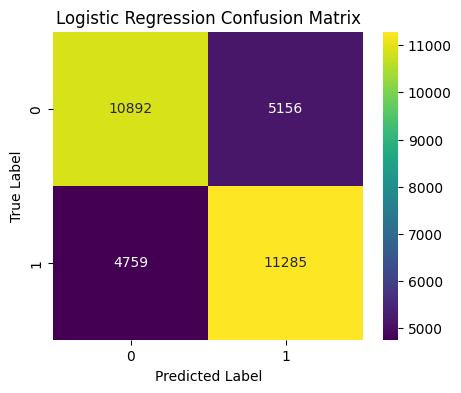

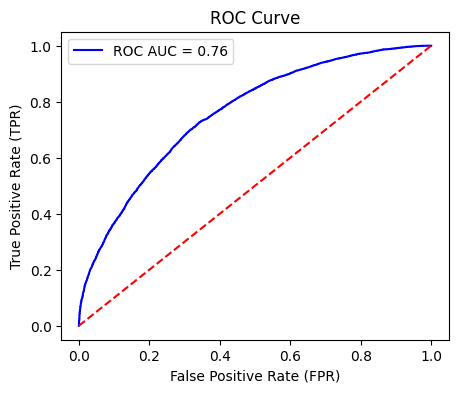


----------Building Decision Tree----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.9370
Test Accuracy: 0.9374

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     16048
           1       0.92      0.95      0.94     16044

    accuracy                           0.94     32092
   macro avg       0.94      0.94      0.94     32092
weighted avg       0.94      0.94      0.94     32092



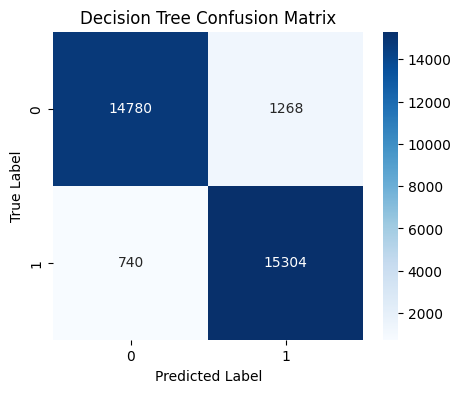

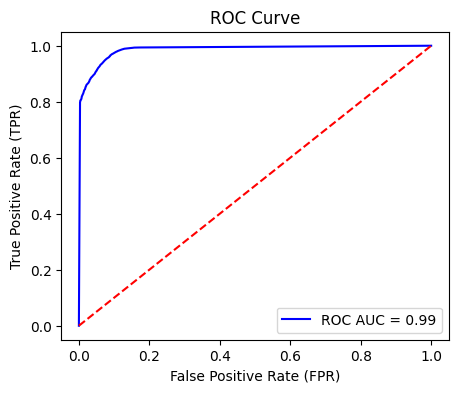


----------Building Random Forest----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}
Best Cross-Validation Score: 0.9421
Test Accuracy: 0.9419

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     16048
           1       0.92      0.96      0.94     16044

    accuracy                           0.94     32092
   macro avg       0.94      0.94      0.94     32092
weighted avg       0.94      0.94      0.94     32092



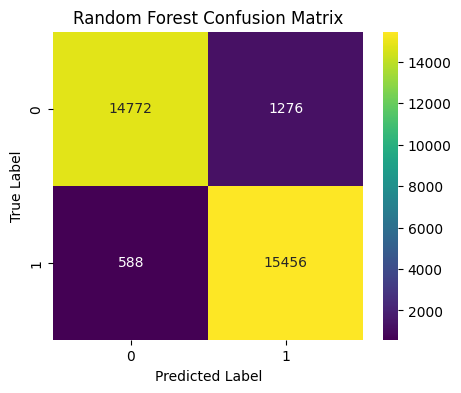

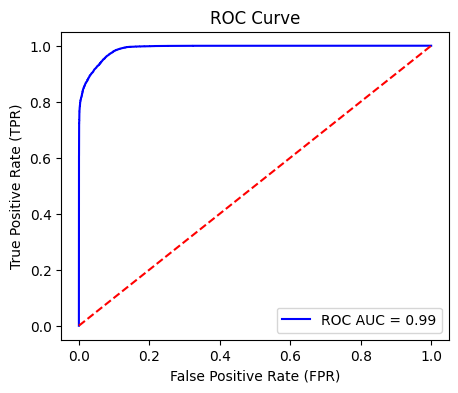


----------Building XGBoost----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[0]	validation_0-logloss:0.66641
[1]	validation_0-logloss:0.63798
[2]	validation_0-logloss:0.60123
[3]	validation_0-logloss:0.57484
[4]	validation_0-logloss:0.55814
[5]	validation_0-logloss:0.53241
[6]	validation_0-logloss:0.52015
[7]	validation_0-logloss:0.49334
[8]	validation_0-logloss:0.47323
[9]	validation_0-logloss:0.45170
[10]	validation_0-logloss:0.43763
[11]	validation_0-logloss:0.41466
[12]	validation_0-logloss:0.40673
[13]	validation_0-logloss:0.39525
[14]	validation_0-logloss:0.39160
[15]	validation_0-logloss:0.38625
[16]	validation_0-logloss:0.37956
[17]	validation_0-logloss:0.37518
[18]	validation_0-logloss:0.35935
[19]	validation_0-logloss:0.35054
[20]	validation_0-logloss:0.34758
[21]	validation_0-logloss:0.34245
[22]	validation_0-logloss:0.33621
[23]	validation_0-logloss:0.32543
[24]	validation_0-logloss:0.32190
[25]	validation_0-logloss:0.31882
[26]	validation_0-logloss:0

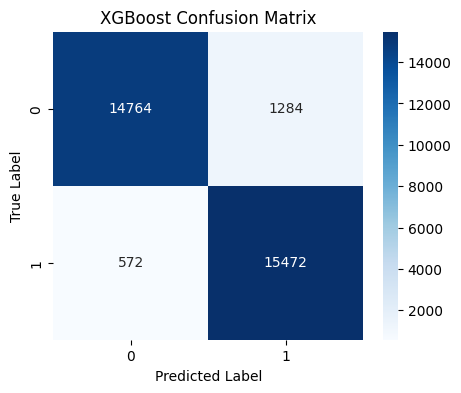

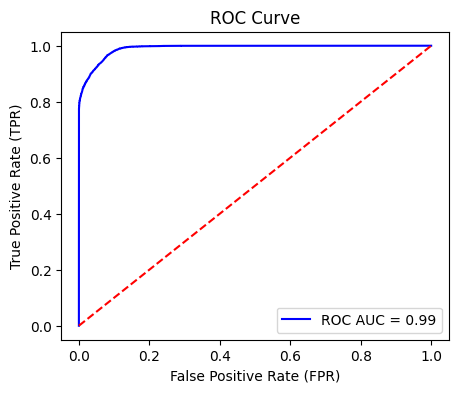


----------Building Neural Network----------
Epoch 1/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.5992 - loss: 0.6902 - val_accuracy: 0.6802 - val_loss: 0.5865
Epoch 2/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.6764 - loss: 0.5885 - val_accuracy: 0.7174 - val_loss: 0.5289
Epoch 3/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7177 - loss: 0.5350 - val_accuracy: 0.7748 - val_loss: 0.4594
Epoch 4/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7493 - loss: 0.4948 - val_accuracy: 0.7996 - val_loss: 0.4199
Epoch 5/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7713 - loss: 0.4593 - val_accuracy: 0.8019 - val_loss: 0.3979
Epoch 6/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7881 - loss: 0.4309 - val_accuracy: 0.8322 - val_loss: 0.3545
Epoch 7/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8050 - loss: 0.4038 - val_accuracy: 0.8487 - val_loss: 0.3270
Epoch 8/50
3210/3210 ━━━━━━━━━━━━━━━━━

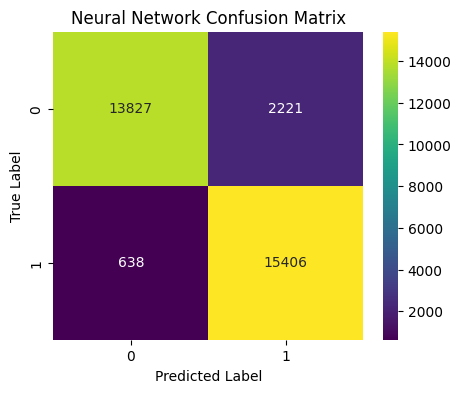

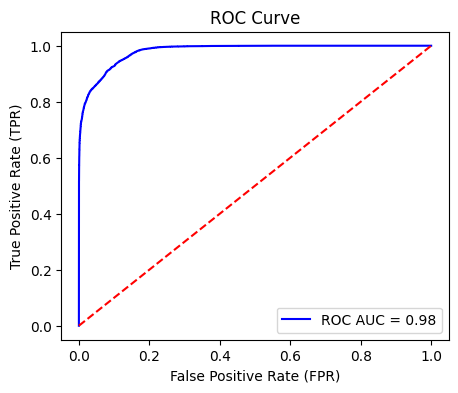


----------Comparing Models----------
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                     Accuracy Roc-Auc Score
XG Boost             0.942166      0.942169
Random Forest        0.941917       0.94192
Decision Tree         0.93743      0.937432
Neural Network       0.910912      0.910919
Logistic Regression  0.691044      0.691046


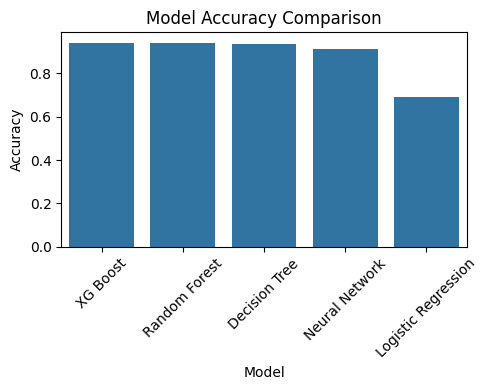


Best Model for Classification: XG Boost saved to 'best_model_class.pkl'


In [ ]:
models, comparison, results, best_model, best_model_name = run_all_models(x_train, x_test, tr_lab, ts_lab)